## Multi-Interest Network with Dynamic Routing (MIMD)

使用设备: cuda
下载并处理MovieLens-1M数据集...
下载MovieLens-1M数据集...
解压数据集...
读取和处理数据...
数据集信息: 物品数量=3953, 训练样本=6038, 验证样本=6038, 测试样本=6038


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


开始训练模型...


  1%|          | 10/1000 [00:42<1:18:44,  4.77s/it]

Epoch 10/1000, Train Loss: 4.3969, Val Loss: 4.6685, LR: 0.001000, Time: 2.77s
验证集指标: HR@10=0.0083, HR@20=0.0121, NDCG@10=0.0040
模型保存: Epoch 10, HR@10=0.0083


  2%|▏         | 20/1000 [01:23<1:15:17,  4.61s/it]

Epoch 20/1000, Train Loss: 4.2515, Val Loss: 4.6549, LR: 0.001000, Time: 2.65s
验证集指标: HR@10=0.0094, HR@20=0.0136, NDCG@10=0.0045
模型保存: Epoch 20, HR@10=0.0094


  3%|▎         | 30/1000 [02:02<1:13:46,  4.56s/it]

Epoch 30/1000, Train Loss: 4.1956, Val Loss: 4.5998, LR: 0.001000, Time: 2.64s
验证集指标: HR@10=0.0119, HR@20=0.0182, NDCG@10=0.0060
模型保存: Epoch 30, HR@10=0.0119


  4%|▍         | 40/1000 [02:43<1:13:40,  4.61s/it]

Epoch 40/1000, Train Loss: 4.1686, Val Loss: 4.5562, LR: 0.001000, Time: 2.69s
验证集指标: HR@10=0.0144, HR@20=0.0230, NDCG@10=0.0083
模型保存: Epoch 40, HR@10=0.0144


  5%|▌         | 50/1000 [03:23<1:12:34,  4.58s/it]

Epoch 50/1000, Train Loss: 4.1548, Val Loss: 4.4946, LR: 0.001000, Time: 2.64s
验证集指标: HR@10=0.0230, HR@20=0.0343, NDCG@10=0.0121
模型保存: Epoch 50, HR@10=0.0230


  6%|▌         | 60/1000 [04:03<1:12:16,  4.61s/it]

Epoch 60/1000, Train Loss: 4.1368, Val Loss: 4.4229, LR: 0.001000, Time: 2.65s
验证集指标: HR@10=0.0278, HR@20=0.0474, NDCG@10=0.0144
模型保存: Epoch 60, HR@10=0.0278


  7%|▋         | 70/1000 [04:43<1:11:13,  4.59s/it]

Epoch 70/1000, Train Loss: 4.1195, Val Loss: 4.3612, LR: 0.001000, Time: 2.62s
验证集指标: HR@10=0.0318, HR@20=0.0533, NDCG@10=0.0159
模型保存: Epoch 70, HR@10=0.0318


  8%|▊         | 80/1000 [05:23<1:10:27,  4.60s/it]

Epoch 80/1000, Train Loss: 4.1068, Val Loss: 4.3116, LR: 0.001000, Time: 2.64s
验证集指标: HR@10=0.0346, HR@20=0.0593, NDCG@10=0.0176
模型保存: Epoch 80, HR@10=0.0346


  9%|▉         | 90/1000 [06:02<1:09:22,  4.57s/it]

Epoch 90/1000, Train Loss: 4.0944, Val Loss: 4.2713, LR: 0.001000, Time: 2.61s
验证集指标: HR@10=0.0371, HR@20=0.0623, NDCG@10=0.0178
模型保存: Epoch 90, HR@10=0.0371


 10%|█         | 100/1000 [06:42<1:08:37,  4.58s/it]

Epoch 100/1000, Train Loss: 4.0854, Val Loss: 4.2430, LR: 0.001000, Time: 2.63s
验证集指标: HR@10=0.0383, HR@20=0.0616, NDCG@10=0.0183
模型保存: Epoch 100, HR@10=0.0383


 11%|█         | 110/1000 [07:22<1:07:54,  4.58s/it]

Epoch 110/1000, Train Loss: 4.0808, Val Loss: 4.2261, LR: 0.001000, Time: 2.64s
验证集指标: HR@10=0.0383, HR@20=0.0605, NDCG@10=0.0184


 12%|█▏        | 120/1000 [08:02<1:07:18,  4.59s/it]

Epoch 120/1000, Train Loss: 4.0758, Val Loss: 4.2145, LR: 0.001000, Time: 2.62s
验证集指标: HR@10=0.0388, HR@20=0.0596, NDCG@10=0.0184


 13%|█▎        | 130/1000 [08:42<1:06:49,  4.61s/it]

Epoch 130/1000, Train Loss: 4.0756, Val Loss: 4.2115, LR: 0.001000, Time: 2.67s
验证集指标: HR@10=0.0378, HR@20=0.0593, NDCG@10=0.0179


 14%|█▍        | 140/1000 [09:22<1:06:04,  4.61s/it]

Epoch 140/1000, Train Loss: 4.0734, Val Loss: 4.2107, LR: 0.001000, Time: 2.65s
验证集指标: HR@10=0.0373, HR@20=0.0601, NDCG@10=0.0178


 15%|█▌        | 150/1000 [10:02<1:05:22,  4.62s/it]

Epoch 150/1000, Train Loss: 4.0691, Val Loss: 4.2085, LR: 0.001000, Time: 2.66s
验证集指标: HR@10=0.0368, HR@20=0.0608, NDCG@10=0.0177


 16%|█▌        | 160/1000 [10:42<1:04:43,  4.62s/it]

Epoch 160/1000, Train Loss: 4.0691, Val Loss: 4.2091, LR: 0.000250, Time: 2.78s
验证集指标: HR@10=0.0378, HR@20=0.0606, NDCG@10=0.0180


 17%|█▋        | 170/1000 [11:23<1:04:26,  4.66s/it]

Epoch 170/1000, Train Loss: 4.0689, Val Loss: 4.2073, LR: 0.000125, Time: 2.66s
验证集指标: HR@10=0.0381, HR@20=0.0606, NDCG@10=0.0180


 18%|█▊        | 180/1000 [12:03<1:02:52,  4.60s/it]

Epoch 180/1000, Train Loss: 4.0692, Val Loss: 4.2078, LR: 0.000063, Time: 2.63s
验证集指标: HR@10=0.0381, HR@20=0.0606, NDCG@10=0.0180


 19%|█▉        | 190/1000 [12:43<1:01:44,  4.57s/it]

Epoch 190/1000, Train Loss: 4.0672, Val Loss: 4.2069, LR: 0.000016, Time: 2.65s
验证集指标: HR@10=0.0381, HR@20=0.0608, NDCG@10=0.0180


 19%|█▉        | 191/1000 [12:50<54:23,  4.03s/it]

早停在epoch 192，验证集HR@10没有提升
加载最佳模型: HR@10=0.0383


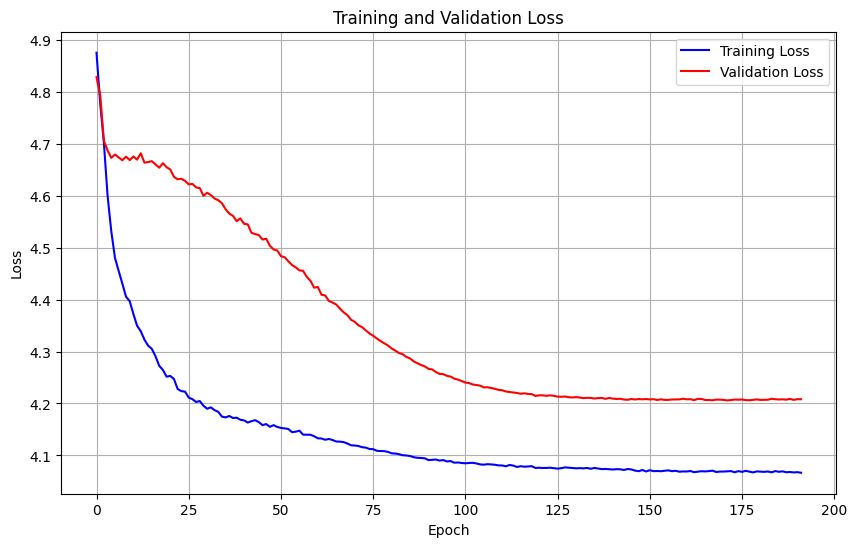

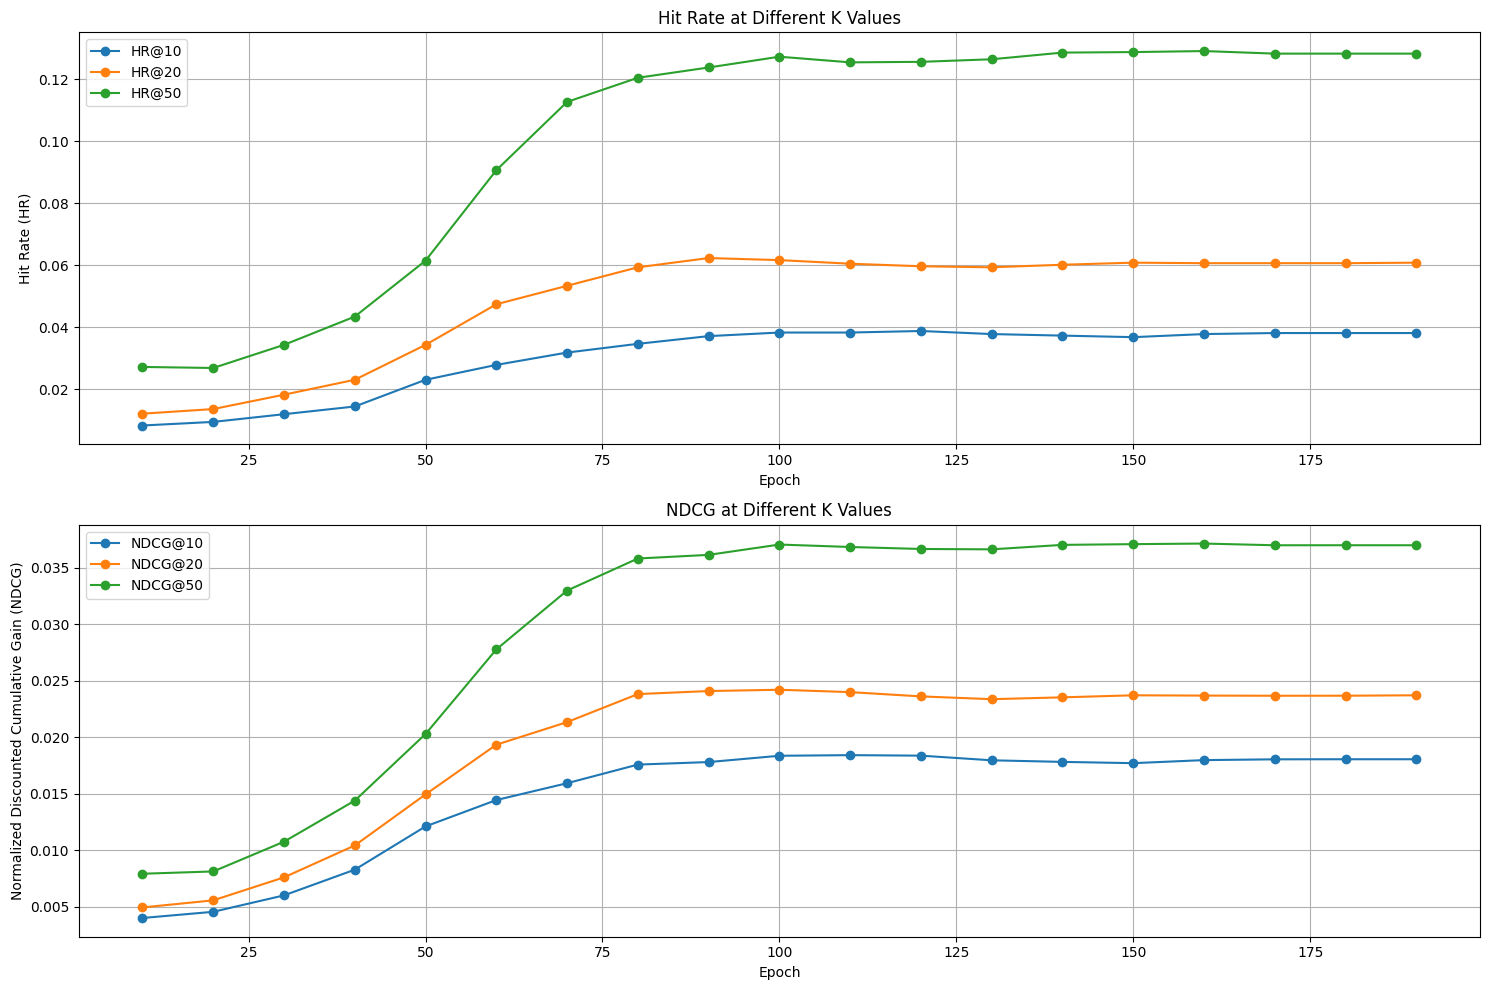

评估训练集性能...
HR@10: 0.0537, NDCG@10: 0.0274
HR@20: 0.0883, NDCG@20: 0.0361
HR@50: 0.1784, NDCG@50: 0.0538
评估验证集性能...
HR@10: 0.0383, NDCG@10: 0.0183
HR@20: 0.0616, NDCG@20: 0.0242
HR@50: 0.1272, NDCG@50: 0.0370
评估测试集性能...
HR@10: 0.0379, NDCG@10: 0.0174
HR@20: 0.0566, NDCG@20: 0.0221
HR@50: 0.1199, NDCG@50: 0.0346


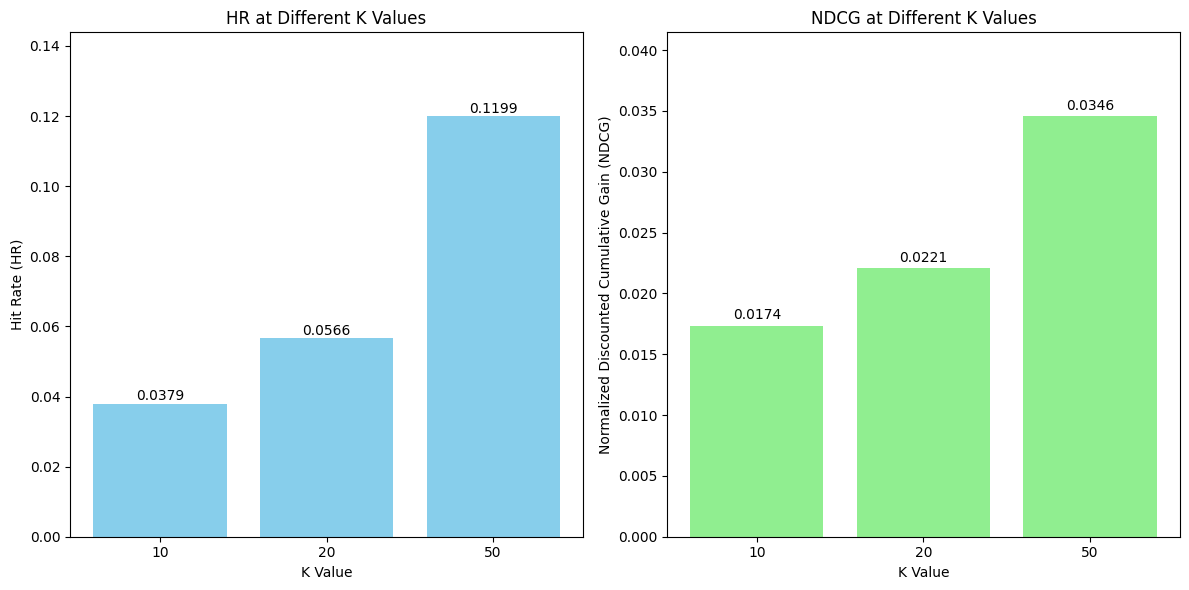

训练和评估完成!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import requests
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn.init import xavier_uniform_
import time

# 设置随机种子，保证结果可复现
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

# 增强版胶囊网络层
class EnhancedCapsuleLayer(nn.Module):
    """增强版胶囊网络层，改进的B2I动态路由算法"""
    def __init__(self, input_units, out_units, max_len, k_max=4, iterations=3, 
                 dropout_rate=0.2, use_layer_norm=True):
        super(EnhancedCapsuleLayer, self).__init__()
        self.input_units = input_units
        self.out_units = out_units
        self.max_len = max_len
        self.k_max = k_max
        self.iterations = iterations
        self.dropout_rate = dropout_rate
        self.use_layer_norm = use_layer_norm
        # 增强的共享权重矩阵
        self.shared_weights = nn.Parameter(torch.Tensor(1, input_units, out_units))
        self.bias = nn.Parameter(torch.Tensor(1, 1, out_units))
        # 非线性变换层
        self.transform = nn.Sequential(
            nn.Linear(input_units, out_units * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(out_units * 2, out_units)
        )
        # 层归一化
        if use_layer_norm:
            self.layer_norm = nn.LayerNorm(out_units)
        # 初始化参数
        self.reset_parameters()
    
    def reset_parameters(self):
        """使用Xavier初始化参数"""
        xavier_uniform_(self.shared_weights)
        nn.init.zeros_(self.bias)
        for layer in self.transform:
            if isinstance(layer, nn.Linear):
                xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, inputs):
        history_emb, hist_len = inputs
        batch_size = history_emb.size(0)
        # 计算每个用户实际需要的兴趣胶囊数量
        k_user = torch.clamp(torch.floor(torch.log2(hist_len.float() + 1e-8)), min=1, max=self.k_max).long()
        # 应用非线性变换
        transformed_emb = self.transform(history_emb)  # (batch_size, seq_len, out_units)
        # 初始化路由权重为零
        b_ij = torch.zeros(batch_size, self.max_len, self.k_max, device=history_emb.device)
        # 动态路由迭代
        for i in range(self.iterations):
            # 路由权重归一化
            c_ij = F.softmax(b_ij, dim=2)  # (batch_size, seq_len, k_max)
            # 应用掩码，屏蔽掉填充的历史行为
            mask = torch.arange(self.max_len, device=hist_len.device).expand(batch_size, self.max_len) >= hist_len.unsqueeze(1)
            c_ij = c_ij.masked_fill(mask.unsqueeze(2), 0)
            # 计算加权输入
            u_hat = torch.matmul(transformed_emb, self.shared_weights) + self.bias
            # 加权求和
            s_j = torch.bmm(c_ij.transpose(1, 2), u_hat)  # (batch_size, k_max, out_units)
            # 层归一化
            if self.use_layer_norm and i < self.iterations - 1:
                s_j = self.layer_norm(s_j)
            # squash操作
            v_j = self.squash(s_j)  # (batch_size, k_max, out_units)
            # 更新路由权重
            if i < self.iterations - 1:
                # 计算相似度 (batch_size, seq_len, k_max)
                u_v = torch.bmm(u_hat, v_j.transpose(1, 2)) 
                # 路由权重更新
                b_ij = b_ij + u_v
        # 根据每个用户的k_user选择前k个兴趣胶囊
        final_v_j = []
        for i in range(batch_size):
            k_val = min(k_user[i], self.k_max)  # 确保不超过最大胶囊数
            final_v_j.append(v_j[i, :k_val, :])
        # 填充到固定维度
        max_k = k_user.max().clamp(max=self.k_max).item()
        output = torch.zeros(batch_size, max_k, self.out_units, device=history_emb.device)
        for i in range(batch_size):
            k_val = min(k_user[i], max_k)
            output[i, :k_val, :] = final_v_j[i]
        return output, k_user
    
    def squash(self, inputs):
        """改进的squash函数，更稳定的向量压缩"""
        norm = torch.norm(inputs, p=2, dim=2, keepdim=True)
        norm_squared = norm ** 2
        scale = norm_squared / (1 + norm_squared) / (norm + 1e-8)
        return scale * inputs
    
    def stable_squash(self, inputs):
        """替代的squash实现，更稳定的版本"""
        norm = torch.norm(inputs, p=2, dim=2, keepdim=True)
        unit_vector = inputs / (norm + 1e-8)
        return norm / (1 + norm) * unit_vector
        
# 标签感知注意力层
class LabelAwareAttention(nn.Module):
    """标签感知注意力层，根据目标物品调整用户的多兴趣表示"""
    def __init__(self, embedding_dim, k_max=4, pow_p=1.0, dynamic_k=False):
        super(LabelAwareAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.k_max = k_max
        self.pow_p = pow_p
        self.dynamic_k = dynamic_k
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.Tanh(),
            nn.Linear(embedding_dim, 1)
        )
    
    def forward(self, inputs):
        if self.dynamic_k and len(inputs) == 3:
            user_embeddings, target_embedding, k_user = inputs
        else:
            user_embeddings, target_embedding = inputs
            k_user = torch.full((user_embeddings.size(0),), self.k_max, dtype=torch.long, device=user_embeddings.device)
        batch_max_k = k_user.max().item()
        batch_size = user_embeddings.size(0)
        processed_user_embeddings = torch.zeros(batch_size, batch_max_k, self.embedding_dim, device=user_embeddings.device)
        for i in range(batch_size):
            actual_k = k_user[i].item()
            user_interest = user_embeddings[i, :actual_k, :]
            # 确保源张量和目标张量维度匹配
            if actual_k > 0:
                if actual_k > batch_max_k:
                    processed_user_embeddings[i] = user_interest[:batch_max_k]  # 截断
                else:
                    processed_user_embeddings[i, :actual_k, :] = user_interest  # 填充
        # 调整目标嵌入的维度以匹配
        target_embedding = target_embedding.expand(-1, batch_max_k, -1)
        # 计算用户兴趣与目标物品的相似度
        concat_vector = torch.cat([processed_user_embeddings, target_embedding], dim=2)
        similarity = self.attention(concat_vector).squeeze(2)  # (batch_size, batch_max_k)
        # 应用掩码，屏蔽掉超出动态k值的兴趣胶囊
        mask = torch.arange(batch_max_k, device=user_embeddings.device).expand(batch_size, batch_max_k) >= k_user.unsqueeze(1)
        similarity = similarity.masked_fill(mask, -1e9)
        # 对相似度应用指数操作，调整注意力分布
        if self.pow_p != 1.0:
            similarity = torch.pow(similarity, self.pow_p)
        # 计算注意力权重
        attention_weights = F.softmax(similarity, dim=1).unsqueeze(2)  # (batch_size, batch_max_k, 1)
        # 加权聚合多兴趣表示
        user_embedding = torch.sum(processed_user_embeddings * attention_weights, dim=1)  # (batch_size, embedding_dim)
        return user_embedding

# MIND模型
class MIND(nn.Module):
    """Multi-Interest Network with Dynamic Routing模型"""
    def __init__(self, item_count, embedding_dim=64, k_max=4, pow_p=1.0, dynamic_k=True):
        super(MIND, self).__init__()
        self.item_count = item_count
        self.embedding_dim = embedding_dim
        self.k_max = k_max
        self.pow_p = pow_p
        self.dynamic_k = dynamic_k
        self.item_embedding = nn.Embedding(item_count, embedding_dim, padding_idx=0)
        # 使用增强胶囊层
        self.capsule_layer = EnhancedCapsuleLayer(
            embedding_dim, 
            embedding_dim, 
            max_len=50, 
            k_max=k_max,
            iterations=4,  # 增加迭代次数
            dropout_rate=0.2,
            use_layer_norm=True
        )
        self.label_aware_attention = LabelAwareAttention(embedding_dim, k_max=k_max, pow_p=pow_p, dynamic_k=dynamic_k)
        
    def forward(self, user_hist, target_item=None, hist_len=None):
        hist_emb = self.item_embedding(user_hist)
        multi_interests, k_user = self.capsule_layer((hist_emb, hist_len))
        if target_item is not None:
            target_emb = self.item_embedding(target_item).unsqueeze(1)
            if self.dynamic_k:
                user_embedding = self.label_aware_attention((multi_interests, target_emb, k_user))
            else:
                user_embedding = self.label_aware_attention((multi_interests, target_emb))
            return user_embedding, multi_interests
        else:
            return multi_interests, k_user
    
    def calculate_loss(self, user_embedding, target_item, num_negatives=100):
        """使用负采样的损失计算"""
        # 获取当前设备
        device = user_embedding.device 
        # 负采样替代全物品计算
        neg_samples = torch.randint(1, self.item_count, 
                                  (target_item.size(0), num_negatives),
                                  device=device)
        # 合并正负样本
        all_items = torch.cat([target_item.unsqueeze(1), neg_samples], dim=1)
        item_emb = self.item_embedding(all_items)  # (batch_size, num_items, emb_dim)
        # 计算用户表示与物品表示的点积相似度
        scores = torch.bmm(
            user_embedding.unsqueeze(1),  # (batch_size, 1, emb_dim)
            item_emb.transpose(1, 2)       # (batch_size, emb_dim, num_items)
        ).squeeze(1)  # (batch_size, num_items)
        # 创建标签：第一个位置是正样本
        labels = torch.zeros(target_item.size(0), dtype=torch.long, device=device)
        return F.cross_entropy(scores, labels)

# 数据集类
class UserItemDataset(Dataset):
    def __init__(self, user_hists, target_items, hist_lens):
        self.user_hists = user_hists
        self.target_items = target_items
        self.hist_lens = hist_lens
        
    def __len__(self):
        return len(self.user_hists)
    
    def __getitem__(self, idx):
        return {
            'user_hist': torch.tensor(self.user_hists[idx], dtype=torch.long),
            'target_item': torch.tensor(self.target_items[idx], dtype=torch.long),
            'hist_len': torch.tensor(self.hist_lens[idx], dtype=torch.long)
        }

# 下载并处理MovieLens数据集
def download_and_preprocess_movielens():
    # 如果数据集不存在，则下载
    data_path = 'ml-1m'
    zip_path = 'ml-1m.zip'
    ratings_file = os.path.join(data_path, 'ratings.dat')
    movies_file = os.path.join(data_path, 'movies.dat')
    if not os.path.exists(data_path):
        if not os.path.exists(zip_path):
            print("下载MovieLens-1M数据集...")
            url = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'
            r = requests.get(url)
            with open(zip_path, 'wb') as f:
                f.write(r.content)
        print("解压数据集...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')
    print("读取和处理数据...")
    # 读取评分数据
    ratings = pd.read_csv(ratings_file, sep='::', 
                         engine='python', 
                         names=['user_id', 'movie_id', 'rating', 'timestamp'])
    # 读取电影元数据（用于获取电影类别）
    movies = pd.read_csv(movies_file, sep='::', 
                        engine='python', 
                        names=['movie_id', 'title', 'genres'],
                        encoding='ISO-8859-1')
    # 构建电影ID到类别的映射
    movie_to_genres = {row['movie_id']: row['genres'] for _, row in movies.iterrows()}
    # 过滤低评分
    ratings = ratings[ratings['rating'] >= 3]  # 只保留评分4分及以上的
    # 按用户分组并按时间排序
    ratings.sort_values(['user_id', 'timestamp'], inplace=True)
    # 构建用户历史序列
    user_sequences = ratings.groupby('user_id')['movie_id'].apply(list).reset_index()
    user_sequences.columns = ['user_id', 'movie_list']
    # 添加序列长度
    user_sequences['hist_len'] = user_sequences['movie_list'].apply(len)
    # 过滤序列长度太短的用户
    user_sequences = user_sequences[user_sequences['hist_len'] >= 6]  # 至少需要6个物品用于划分
    # 更合理的序列拆分逻辑
    def split_sequence(row):
        seq = row['movie_list']
        # 训练集：前80%序列预测第80%位置的物品
        split_idx = int(len(seq)*0.8)
        train_hist, train_target = seq[:split_idx], seq[split_idx]
        # 验证集：前90%序列预测第90%位置的物品
        split_idx_val = int(len(seq)*0.9)
        val_hist, val_target = seq[:split_idx_val], seq[split_idx_val]
        # 测试集：全序列预测最后一个物品
        test_hist, test_target = seq[:-1], seq[-1]
        return train_hist, train_target, val_hist, val_target, test_hist, test_target
    # 应用序列拆分
    user_sequences[['train_hist', 'train_target', 'val_hist', 'val_target', 'test_hist', 'test_target']] = user_sequences.apply(
        lambda row: split_sequence(row), axis=1, result_type='expand')
    # 获取物品数量
    num_items = ratings['movie_id'].max() + 1  # +1 因为ID从1开始
    # 填充序列到固定长度
    max_len = 50
    def pad_sequences(sequences, max_len, pad_value=0):
        padded = []
        for seq in sequences:
            if len(seq) < max_len:
                padded.append(seq + [pad_value] * (max_len - len(seq)))
            else:
                padded.append(seq[:max_len])
        return padded
    # 准备训练集数据
    train_user_hists = pad_sequences(user_sequences['train_hist'].tolist(), max_len)
    train_target_items = user_sequences['train_target'].tolist()
    train_hist_lens = [min(len(h), max_len) for h in user_sequences['train_hist']]
    # 准备验证集数据
    val_user_hists = pad_sequences(user_sequences['val_hist'].tolist(), max_len)
    val_target_items = user_sequences['val_target'].tolist()
    val_hist_lens = [min(len(h), max_len) for h in user_sequences['val_hist']]
    # 准备测试集数据
    test_user_hists = pad_sequences(user_sequences['test_hist'].tolist(), max_len)
    test_target_items = user_sequences['test_target'].tolist()
    test_hist_lens = [min(len(h), max_len) for h in user_sequences['test_hist']]
    
    return (train_user_hists, train_target_items, train_hist_lens,
            val_user_hists, val_target_items, val_hist_lens,
            test_user_hists, test_target_items, test_hist_lens,
            num_items, movie_to_genres)

# 训练函数
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=10):
    train_losses = []
    val_losses = []
    metrics_history = {
        'HR@10': [], 'HR@20': [], 'HR@50': [],
        'NDCG@10': [], 'NDCG@20': [], 'NDCG@50': []
    }
    best_val_loss = float('inf')
    best_hr10 = 0.0
    patience = 20
    counter = 0
    best_metrics = None
    model_path = 'best_mind_model.pth'
    for epoch in tqdm(range(epochs)):
        # 训练阶段
        model.train()
        total_train_loss = 0
        start_time = time.time()
        for batch in train_loader:
            user_hist = batch['user_hist'].to(device)
            target_item = batch['target_item'].to(device)
            hist_len = batch['hist_len'].to(device)
            optimizer.zero_grad()
            user_embedding, _ = model(user_hist, target_item, hist_len)
            loss = model.calculate_loss(user_embedding, target_item)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        end_time = time.time()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss) 
        # 验证阶段
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                user_hist = batch['user_hist'].to(device)
                target_item = batch['target_item'].to(device)
                hist_len = batch['hist_len'].to(device)
                user_embedding, _ = model(user_hist, target_item, hist_len)
                loss = model.calculate_loss(user_embedding, target_item)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        # 更新学习率
        scheduler.step(avg_val_loss)
        # 每10个epoch评估一次模型
        val_hr10 = 0.0  # 初始化val_hr10，避免未定义错误
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            metrics = evaluate_model(model, val_loader, device, flag_print=False)
            val_hr10 = metrics['HR@10']
            for key, value in metrics.items():
                metrics_history[key].append(value)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}, Time: {end_time-start_time:.2f}s')
            print(f"验证集指标: HR@10={val_hr10:.4f}, HR@20={metrics['HR@20']:.4f}, NDCG@10={metrics['NDCG@10']:.4f}")
            # 保存最佳指标
            if best_metrics is None or metrics['HR@10'] > best_metrics['HR@10']:
                best_metrics = metrics
        # 保存最佳模型
        if val_hr10 > best_hr10 + 0.001:  # 微小改进也保存
            best_hr10 = val_hr10
            best_model_state = model.state_dict()
            counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"模型保存: Epoch {epoch+1}, HR@10={val_hr10:.4f}")
        elif avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"早停在epoch {epoch+1}，验证集HR@10没有提升")
                break
    # 加载最佳模型
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"加载最佳模型: HR@10={best_hr10:.4f}")
    
    return train_losses, val_losses, metrics_history, best_metrics

# 评估函数
def evaluate_model(model, data_loader, device, top_k_list=[10, 20, 50], flag_print=True):
    model.eval()
    metrics = {f'HR@{k}': [] for k in top_k_list}
    metrics.update({f'NDCG@{k}': [] for k in top_k_list})
    with torch.no_grad():
        for batch in data_loader:
            user_hist = batch['user_hist'].to(device)
            target_item = batch['target_item'].to(device)
            hist_len = batch['hist_len'].to(device)
            # 获取用户表示
            user_embedding, _ = model(user_hist, target_item, hist_len)
            # 获取所有物品的嵌入
            all_item_emb = model.item_embedding.weight
            # 计算分数
            scores = torch.matmul(user_embedding, all_item_emb.t())
            # 排除历史物品
            for i in range(user_hist.size(0)):
                hist_items = torch.unique(user_hist[i][:hist_len[i]])
                scores[i, hist_items] = -10e8  # 设置为极小值
            # 计算指标
            for k in top_k_list:
                _, top_indices = torch.topk(scores, k, dim=1)
                for i in range(user_hist.size(0)):
                    if target_item[i] in top_indices[i]:
                        metrics[f'HR@{k}'].append(1)
                        rank = (top_indices[i] == target_item[i]).nonzero().item() + 1
                        metrics[f'NDCG@{k}'].append(1 / math.log2(rank + 1))
                    else:
                        metrics[f'HR@{k}'].append(0)
                        metrics[f'NDCG@{k}'].append(0)
    # 计算平均指标
    avg_metrics = {}
    for k in top_k_list:
        avg_metrics[f'HR@{k}'] = torch.tensor(metrics[f'HR@{k}']).float().mean().item()
        avg_metrics[f'NDCG@{k}'] = torch.tensor(metrics[f'NDCG@{k}']).float().mean().item()
    if flag_print:
        for k in top_k_list:
            hr = avg_metrics[f'HR@{k}']
            ndcg = avg_metrics[f'NDCG@{k}']
            print(f'HR@{k}: {hr:.4f}, NDCG@{k}: {ndcg:.4f}')
    
    return avg_metrics

# 绘制损失曲线
def plot_losses(train_losses, val_losses, save_path='loss_curve.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# 绘制指标曲线
def plot_metrics(metrics_history, save_path='metrics_curve.png'):
    plt.figure(figsize=(15, 10))
    # 获取评估的epoch列表
    eval_epochs = [(i+1)*10 for i in range(len(metrics_history['HR@10']))]
    # 绘制HR指标对比
    plt.subplot(2, 1, 1)
    for k in [10, 20, 50]:
        plt.plot(eval_epochs, metrics_history[f'HR@{k}'], 'o-', label=f'HR@{k}')
    plt.xlabel('Epoch')
    plt.ylabel('Hit Rate (HR)')
    plt.title('Hit Rate at Different K Values')
    plt.legend()
    plt.grid(True)
    # 绘制NDCG指标
    plt.subplot(2, 1, 2)
    for k in [10, 20, 50]:
        plt.plot(eval_epochs, metrics_history[f'NDCG@{k}'], 'o-', label=f'NDCG@{k}')
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Discounted Cumulative Gain (NDCG)')
    plt.title('NDCG at Different K Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# 绘制不同K值的最终指标对比
def plot_final_metrics(metrics, save_path='final_metrics.png'):
    k_values = [10, 20, 50]
    hr_values = [metrics[f'HR@{k}'] for k in k_values]
    ndcg_values = [metrics[f'NDCG@{k}'] for k in k_values]
    plt.figure(figsize=(12, 6))
    # 绘制HR指标对比
    plt.subplot(1, 2, 1)
    plt.bar([str(k) for k in k_values], hr_values, color='skyblue')
    plt.xlabel('K Value')
    plt.ylabel('Hit Rate (HR)')
    plt.title('HR at Different K Values')
    plt.ylim(0, max(hr_values) * 1.2)
    # 为每个条形添加数值标签
    for i, v in enumerate(hr_values):
        plt.text(i, v + 0.001, f'{v:.4f}', ha='center')
    # 绘制NDCG指标对比
    plt.subplot(1, 2, 2)
    plt.bar([str(k) for k in k_values], ndcg_values, color='lightgreen')
    plt.xlabel('K Value')
    plt.ylabel('Normalized Discounted Cumulative Gain (NDCG)')
    plt.title('NDCG at Different K Values')
    plt.ylim(0, max(ndcg_values) * 1.2)
    # 为每个条形添加数值标签
    for i, v in enumerate(ndcg_values):
        plt.text(i, v + 0.0005, f'{v:.4f}', ha='center')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# 主函数
def main():
    # 设置参数
    embedding_dim = 64
    k_max = 5
    pow_p = 1.0
    dynamic_k = True
    batch_size = 256
    epochs = 1000
    learning_rate = 0.001
    weight_decay = 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    print("下载并处理MovieLens-1M数据集...")
    (train_user_hists, train_target_items, train_hist_lens,
     val_user_hists, val_target_items, val_hist_lens,
     test_user_hists, test_target_items, test_hist_lens,
     num_items, movie_to_genres) = download_and_preprocess_movielens()
    print(f"数据集信息: 物品数量={num_items}, 训练样本={len(train_user_hists)}, "
          f"验证样本={len(val_user_hists)}, 测试样本={len(test_user_hists)}")
    # 创建数据加载器
    train_dataset = UserItemDataset(train_user_hists, train_target_items, train_hist_lens)
    val_dataset = UserItemDataset(val_user_hists, val_target_items, val_hist_lens)
    test_dataset = UserItemDataset(test_user_hists, test_target_items, test_hist_lens)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # 初始化模型
    model = MIND(num_items, embedding_dim, k_max, pow_p, dynamic_k).to(device)
    # 定义优化器和学习率调度器
    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=learning_rate, 
                            weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    # 训练模型
    print("开始训练模型...")
    train_losses, val_losses, metrics_history, best_metrics = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, epochs)
    # 绘制损失曲线
    plot_losses(train_losses, val_losses, save_path='mind_loss_curve.png')
    # 绘制指标曲线
    plot_metrics(metrics_history, save_path='mind_metrics_curve.png')
    # 加载最佳模型并在测试集上评估
    print("评估训练集性能...")
    train_metrics = evaluate_model(model, train_loader, device)
    print("评估验证集性能...")
    val_metrics = evaluate_model(model, val_loader, device)
    print("评估测试集性能...")
    test_metrics = evaluate_model(model, test_loader, device)
    # 绘制不同K值的最终指标对比
    plot_final_metrics(test_metrics, save_path='best_metrics.png')
    print("训练和评估完成!")
    return model, test_metrics

if __name__ == "__main__":
    model, metrics = main()